In [294]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score, cross_val_predict, train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from pymongo import *
from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [15]:
# Import the spray data so that we can perform clustering analysis on it.
df = pd.read_csv('https://raw.githubusercontent.com/cl65610/west_nile/master/assets/spray.csv')

In [5]:
df.head()

,Time,Latitude,Longitude
Date,,,
2011-08-29,6:56:58 PM,42.391623,-88.089163
2011-08-29,6:57:08 PM,42.391348,-88.089163
2011-08-29,6:57:18 PM,42.391022,-88.089157
2011-08-29,6:57:28 PM,42.390637,-88.089158
2011-08-29,6:57:38 PM,42.390410,-88.088858


In [6]:
# Set our features for this clustering. 
X = df[['Longitude', 'Latitude']]

In [151]:
# After much tinkering, these parameters gave us what appeared to be an ideal number of groups
dbscn = DBSCAN(eps = .0049, min_samples = 80).fit(X)  
labels = dbscn.labels_

In [253]:
print 'This DBSCAN results in the creation of %d different labels.' % len(set(labels))

This DBSCAN results in the creation of 15 different labels.


In [256]:
print 'The Silhouette Coefficient for this model is: %0.3f.' % metrics.silhouette_score(X, labels)

The Silhouette Coefficient for this model is: 0.413.


In [257]:
# We will now treat these labels as a new feature of our data. Attaching them to our original dataframe will allow us to 
# plot them and visualize our accuracy.
labels_df = pd.DataFrame(labels.reshape(14835,1), columns = ['labels'])

In [258]:
# This merged dataframe is also the dataframe that we'll send up to sql to be joined on. 
merged_df = df.join(labels_df)
merged_df.head()

,Date,Time,Latitude,Longitude,labels
0,2011-08-29,6:56:58 PM,42.391623,-88.089163,0
1,2011-08-29,6:57:08 PM,42.391348,-88.089163,0
2,2011-08-29,6:57:18 PM,42.391022,-88.089157,0
3,2011-08-29,6:57:28 PM,42.390637,-88.089158,0
4,2011-08-29,6:57:38 PM,42.390410,-88.088858,0


In [259]:
svm = SVC()
X = merged_df[['Latitude', 'Longitude']]
y = merged_df['labels']
x_train, x_test, y_train, y_test = train_test_split(X, y)
svm.fit(x_train, y_train)
preds = svm.predict(x_test)
print 'The score for a RBF-SVM is %.4f' % svm.score(x_test, y_test)

The score for a RBF-SVM is 0.7697


In [262]:
knn = KNeighborsClassifier()
neigh = range(1,65)
param_dict = {'n_neighbors':neigh, 'weights':['uniform', 'distance']}
clf = GridSearchCV(knn, param_dict, cv=12, verbose = 1, n_jobs = -1)
clf.fit(X,y)
print 'The best score for our grid-searched KNN classifier is %.4f'% clf.best_score_

Fitting 12 folds for each of 128 candidates, totalling 1536 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:   13.0s


The best score for our grid-searched KNN classifier is 0.9642


[Parallel(n_jobs=-1)]: Done 1536 out of 1536 | elapsed:   31.2s finished


In [265]:
rf = RandomForestClassifier()
rf_fit = rf.fit(X,y)
print 'The score for our Random Forest model is %.5f.' % rf.score(X, y)
# After seeing the high score with this model, we saved the fit as the variable rf_fit. This way, we can use the fit to
# predict the spray zones for our train data.

The score for our Random Forest model is 0.99966.


In [266]:
# In order to test our accuracy, we will import our train data, apply the fit, and check visually to see how well our
# classifier performs.
train_df = pd.read_csv('https://raw.githubusercontent.com/cl65610/west_nile/master/assets/train.csv')

In [ ]:
# As above, our features for this will be latitude and longitude. 
X2 = df2[['Latitude', 'Longitude']]

In [268]:
# Here we predict what our train data spray zones will be and set those results equal to a dataframe that we can then join 
# onto our training data.
label_predicts = rf_fit.predict(X2)
rf_labels = pd.DataFrame(predictions, columns = ['rf_labels'])

In [269]:
labeled_df = df2.join(rf_labels)

In [271]:
labeled_df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,rf_labels
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,7
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,7
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,2
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,1
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,1


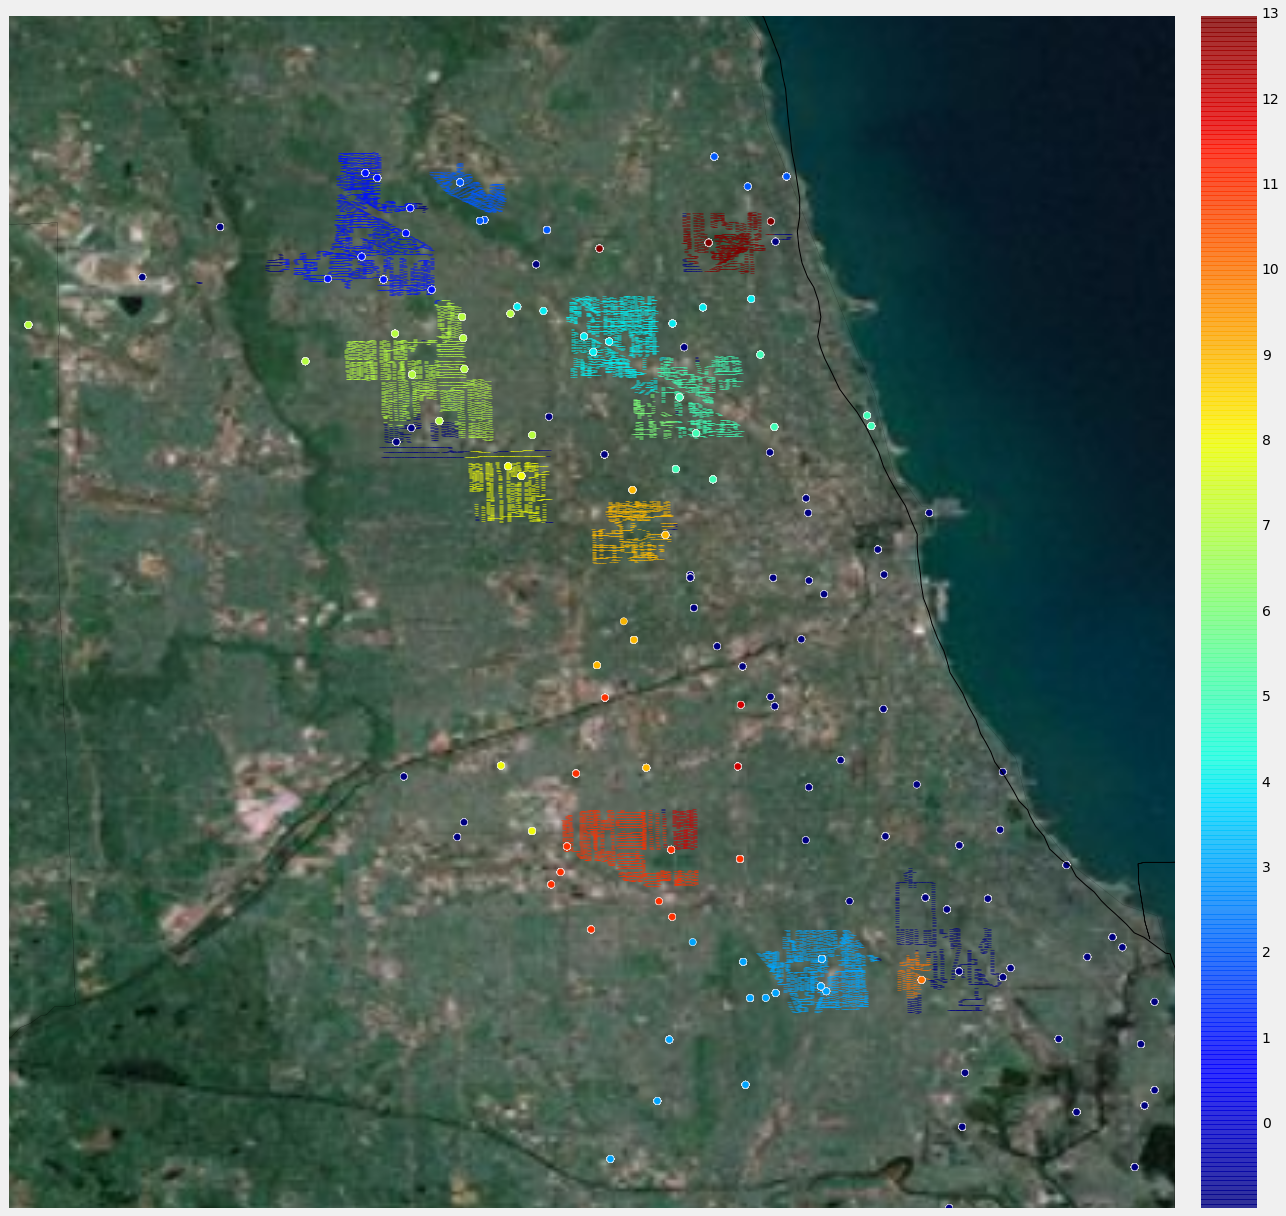

In [307]:
plt.figure(figsize=(20,20))
plt.style.use('fivethirtyeight')
m = Basemap(llcrnrlon=-87.938515,llcrnrlat=41.6443349,urcrnrlon=-87.524044,urcrnrlat=42.068155456,
                projection='cyl',resolution='f')
    # draw coastlines.
m.drawcoastlines()
m.drawstates()
m.drawrivers()
m.drawcounties()
m.drawcountries()
m.drawstates()
m.arcgisimage()

m.scatter(merged_df.Longitude, merged_df.Latitude, c=merged_df['labels'], s=15, marker='_')
m.scatter(labeled_df.Longitude, labeled_df.Latitude, c=labeled_df['rf_labels'], s=50, alpha = 0.8,marker = 'o')
m.colorbar(ticks=range(len(set(merged_df['labels']))))
plt.show()

Run a dbscan on our spray data to determine what the clusters of spraying are. After doing this, we have engineered a new feature for our spray data: the "spray zone." We can use this information to help us determine what spray zone a mosquito trap falls into. This process, unfortunately, is not quite as straightforward as we would have liked. In order to make this actionable we trained several classifiers on our spray data with the spray zone label set as the target. We then applied this model fit to our train data, thereby giving us a sense of which spray zone a trap fell into. This also importantly gave us a second feature that we could use to join our spray data onto our trap information. Unfortunately, there isn't a reliably easy way to join on two columns in pandas. The pythonic solution require creating a multiindex object that can be joined on.  To workaround this problem, we will send our two dataframes to a local sql database, join them there, and then pull down the properly joined results.


In [250]:
s1.shape

(119514, 14)

In [243]:
test_join.shape

(10506, 14)